<h1>About this Notebook</h1>

This notebook demonstrates the experience of using ML Workbench to create a machine learning model for text classification and setting it up for online prediction. This is the "cloud run" version of previous notebook. Preprocessing, training, batch prediction, are all done in cloud with various of services. The cloud run can be distributed, so it can handle really large data. Although in this case there is little benefit with the small demo data, the purpose is to demonstrate the usage of cloud run mode of ML Workbench.

There are only a few things that need to change between "local run" and "cloud run":

* all data sources or file paths must be on GCS.
* the --cloud flag must be set for each step.
* "cloud_config" can be set for cloud specific settings, such as project_id, machine_type. In some cases it is required.

Other than this, nothing else changes from local to cloud!
    
If you have any feedback, please send them to datalab-feedback@google.com.

# Validate Data

Assuming you have run the previous notebook (Text classification with MLWorkbench (small dataset experience)) so you already have cleaned data saved.

In [2]:
# Make sure you have the processed data there.
!ls ./data

eval.csv  train.csv  vocab.txt


# Create Model with ML Workbench

The MLWorkbench Magics are a set of Datalab commands that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a text classification model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

For details of each command, run with --help. For example, "%%ml train --help".

This notebook shows the cloud version of every command, and gives the normal experience when building models are large datasets. However, we will still use the 20 newsgroup data. 


## Setup: Move the data to GCS

The csv files, and all input files to the MLWorkbench magics must exist on GCS first. Therefore the first step is to make a new GCS bucket and copy the local csv files to GCS. 


In [4]:
!gsutil mb gs://datalab-mlworkbench-20newslab

Creating gs://datalab-mlworkbench-20newslab/...


In [5]:
!gsutil -m cp ./data/train.csv ./data/eval.csv gs://datalab-mlworkbench-20newslab

Copying file://./data/train.csv [Content-Type=text/csv]...
Copying file://./data/eval.csv [Content-Type=text/csv]...
\ [2/2 files][ 11.7 MiB/ 11.7 MiB] 100% Done                                    
Operation completed over 2 objects/11.7 MiB.                                     


In [1]:
import google.datalab.contrib.mlworkbench.commands  # This loads the '%%ml' magics

In [7]:
%%ml dataset create
name: newsgroup_data_gcs
format: csv
schema:
  - name: news_label
    type: STRING
  - name: text
    type: STRING  
train: gs://datalab-mlworkbench-20newslab/train.csv
eval: gs://datalab-mlworkbench-20newslab/eval.csv    

## Step 1: Analyze

In cloud run, analysis is implemented with BigQuery. Running it may incur some costs.

In [8]:
%%ml analyze --cloud
output: gs://datalab-mlworkbench-20newslab/analysis
data: newsgroup_data_gcs
features:
    news_label:
        transform: target
    text:
        transform: bag_of_words

Analyzing column news_label...
column news_label analyzed.
Analyzing column text...
Updated property [core/project].
column text analyzed.
Updated property [core/project].


## Step 2: Transform

In cloud run, analysis is implemented with Cloud DataFlow. Running it may incur some costs.

In [ ]:
!gsutil -m rm -rf gs://datalab-mlworkbench-20newslab/transform # Delete previous results if any.

In [12]:
%%ml transform --cloud
output: gs://datalab-mlworkbench-20newslab/transform
analysis: gs://datalab-mlworkbench-20newslab/analysis
data: newsgroup_data_gcs

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
copying files to trainer-1.0.0...
copying setup.py -> trainer-1.0.0
copying trainer/__init__.py -> trainer-1.0.0/trainer
copying trainer/feature_analysis.py -> trainer-1.0

Click the links in output cell to monitor the jobs progress. Once they are completed (usually within 15 minutes with the job startup overhead), check the output.

In [13]:
!gsutil ls gs://datalab-mlworkbench-20newslab/transform

gs://datalab-mlworkbench-20newslab/transform/errors_eval-00000-of-00001.txt
gs://datalab-mlworkbench-20newslab/transform/errors_train-00000-of-00001.txt
gs://datalab-mlworkbench-20newslab/transform/eval-00000-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/eval-00001-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/eval-00002-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/train-00000-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/train-00001-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/train-00002-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/tmp/


In [2]:
%%ml dataset create
name: newsgroup_data_gcs_transformed
format: transformed
train: gs://datalab-mlworkbench-20newslab/transform/train-*
eval: gs://datalab-mlworkbench-20newslab/transform/eval-*    

## Step 3: Training

In cloud run, training is implemented with Cloud ML Engine Training service. Running it may incur some costs.

In [ ]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!gsutil -m rm -fr gs://datalab-mlworkbench-20newslab/train

Note that, "runtime_version: '1.2'" specifies which TensorFlow version is used at training. The first time training is a bit slower because of warm up, but if you train it multiple times the runs after first will be faster.

In [3]:
%%ml train --cloud
output: gs://datalab-mlworkbench-20newslab/train
analysis: gs://datalab-mlworkbench-20newslab/analysis
data: newsgroup_data_gcs_transformed
model_args:
    model: linear_classification
    top-n: 5
cloud_config:
    scale_tier: BASIC
    region: us-central1
    runtime_version: '1.2'

Job "trainer_task_171019_223905" submitted. Click here to view cloud log.

TensorBoard was started successfully with pid 589. Click here to access it.

In [4]:
# Once training is done, check the output.
!gsutil list gs://datalab-mlworkbench-20newslab/train

gs://datalab-mlworkbench-20newslab/train/schema_without_target.json
gs://datalab-mlworkbench-20newslab/train/evaluation_model/
gs://datalab-mlworkbench-20newslab/train/model/
gs://datalab-mlworkbench-20newslab/train/staging/
gs://datalab-mlworkbench-20newslab/train/train/


## Step 4: Evaluation using batch prediction

See previous notebook (Text Classification --- 20NewsGroup (small data)). You can do local batch prediction with the model trained in cloud.

In [2]:
%%ml batch_predict
model: gs://datalab-mlworkbench-20newslab/train/evaluation_model
output: gs://datalab-mlworkbench-20newslab/prediction
format: csv
data:
  csv: gs://datalab-mlworkbench-20newslab/eval.csv

local prediction...
INFO:tensorflow:Restoring parameters from gs://datalab-mlworkbench-20newslab/train/evaluation_model/variables/variables
done.


In [2]:
!gsutil ls gs://datalab-mlworkbench-20newslab/prediction/

gs://datalab-mlworkbench-20newslab/prediction/
gs://datalab-mlworkbench-20newslab/prediction/predict_results_eval.csv
gs://datalab-mlworkbench-20newslab/prediction/predict_results_schema.json


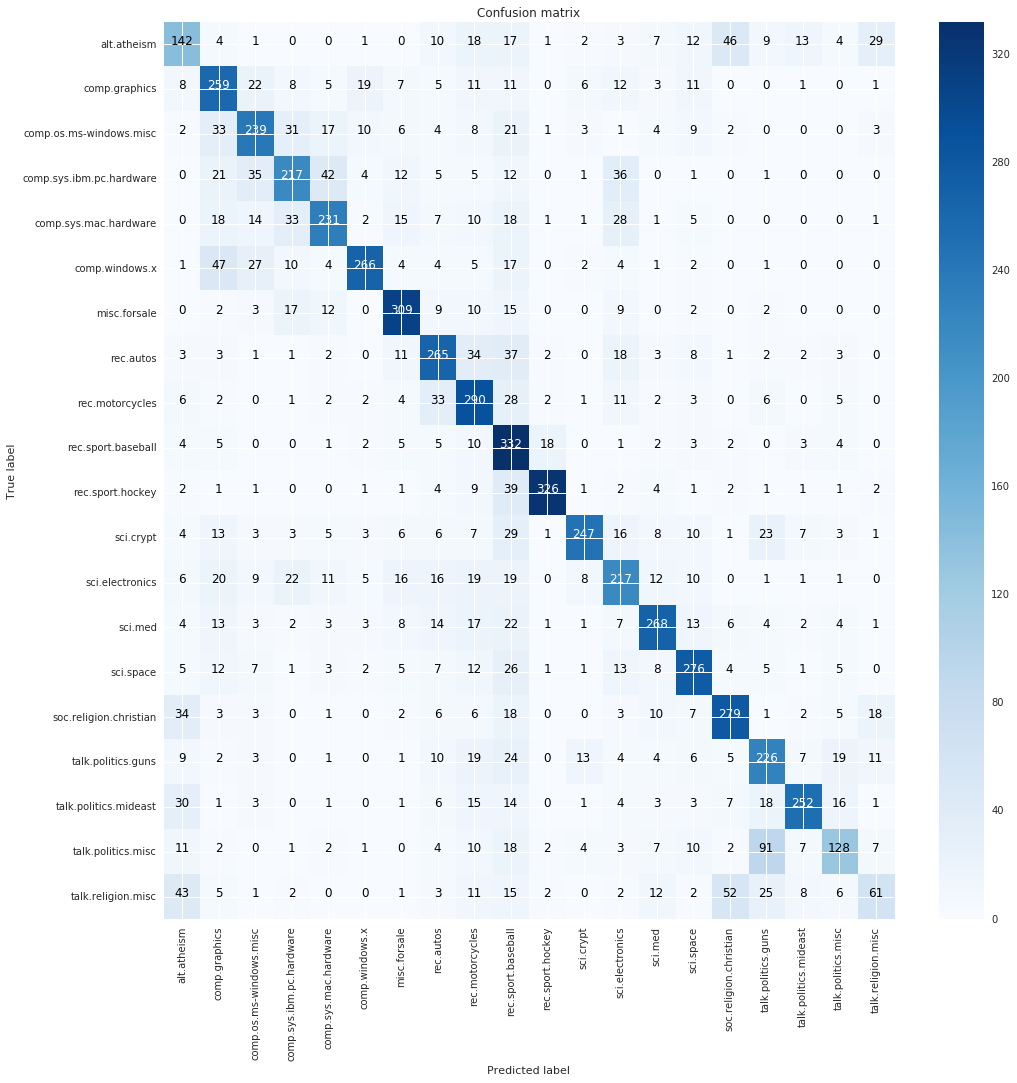

In [5]:
%%ml evaluate confusion_matrix --plot
size: 15
csv: gs://datalab-mlworkbench-20newslab/prediction/predict_results_eval.csv

In [6]:
%%ml evaluate accuracy
csv: gs://datalab-mlworkbench-20newslab/prediction/predict_results_eval.csv

,accuracy,count,target
0,0.445141,319,alt.atheism
1,0.665810,389,comp.graphics
2,0.606599,394,comp.os.ms-windows.misc
3,0.553571,392,comp.sys.ibm.pc.hardware
4,0.600000,385,comp.sys.mac.hardware
5,0.673418,395,comp.windows.x
6,0.792308,390,misc.forsale
7,0.669192,396,rec.autos
8,0.728643,398,rec.motorcycles
9,0.836272,397,rec.sport.baseball


# Prediction

## Local Instant Prediction

Local instant prediction works with model trained in cloud too.

In [7]:
%%ml predict
model: gs://datalab-mlworkbench-20newslab/train/model
data:
  - nasa
  - windows xp

predicted,predicted_2,predicted_3,predicted_4,predicted_5,probability,probability_2,probability_3,probability_4,probability_5,text
sci.space,rec.motorcycles,comp.graphics,rec.sport.baseball,rec.autos,0.099317,0.063897,0.062198,0.061433,0.056892,nasa
comp.os.ms-windows.misc,comp.graphics,comp.windows.x,misc.forsale,rec.motorcycles,0.153955,0.068175,0.063610,0.062289,0.056323,windows xp


## Deploying Model to ML Engine

In [8]:
%%ml model deploy
name: newsgroup.alpha
path: gs://datalab-mlworkbench-20newslab/train/model

Waiting for operation "projects/bradley-playground/operations/create_newsgroup_alpha-1508459499009"
Done.


## Batch Prediction

In [9]:
# Let's create a CSV file from eval.csv by removing the target column.
with open('./data/eval.csv', 'r') as f, open('./data/test.csv', 'w') as fout:
    for l in f:
        fout.write(l.split(',')[1])

In [12]:
!gsutil cp ./data/test.csv gs://datalab-mlworkbench-20newslab/test.csv

Copying file://./data/test.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/4.2 MiB.                                      


In [13]:
%%ml batch_predict --cloud
model: newsgroup.alpha
output: gs://datalab-mlworkbench-20newslab/test
format: json
data:
    csv: gs://datalab-mlworkbench-20newslab/test.csv
cloud_config:
    region: us-central1

Job "prediction_171020_003440" submitted. Click here to view cloud log.

Once job is completed, take a look at the results.

In [14]:
!gsutil ls -lh gs://datalab-mlworkbench-20newslab/test

      42 B  2017-10-20T00:38:10Z  gs://datalab-mlworkbench-20newslab/test/prediction.errors_stats-00000-of-00001
 44.82 KiB  2017-10-20T00:38:14Z  gs://datalab-mlworkbench-20newslab/test/prediction.results-00000-of-00002
293.54 KiB  2017-10-20T00:38:14Z  gs://datalab-mlworkbench-20newslab/test/prediction.results-00001-of-00002
TOTAL: 3 objects, 346523 bytes (338.4 KiB)


In [15]:
!gsutil cat gs://datalab-mlworkbench-20newslab/test/prediction.results* | head -n 2

{"probability": 0.3283481001853943, "probability_5": 0.05025269091129303, "probability_4": 0.0888153463602066, "predicted": "talk.politics.guns", "probability_3": 0.08881844580173492, "probability_2": 0.10015636682510376, "predicted_2": "talk.politics.misc", "predicted_3": "talk.politics.mideast", "predicted_4": "rec.motorcycles", "predicted_5": "talk.religion.misc"}
{"probability": 0.9899819493293762, "probability_5": 0.00031947894603945315, "probability_4": 0.0009666418773122132, "predicted": "sci.space", "probability_3": 0.0011659186566248536, "probability_2": 0.006039201747626066, "predicted_2": "talk.politics.misc", "predicted_3": "sci.crypt", "predicted_4": "talk.politics.guns", "predicted_5": "comp.os.ms-windows.misc"}


## Prediction from a python client

See the previous notebook in this sequence for the example. 

# Clean up

This section is optional. We will delete all the GCP resources and local files created in this sequence of notebooks. If you are not ready to delete anything, don't run any of the following cells.


In [16]:
%%ml model delete
name: newsgroup.alpha

Waiting for operation "projects/bradley-playground/operations/delete_newsgroup_alpha-1508460012953"
Done.


In [ ]:
%%ml model delete
name: newsgroup

In [ ]:
# Delete the files in the GCS bucket, and delete the bucket
!gsutil -m rm -r gs://datalab-mlworkbench-20newslab